In [15]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [16]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [17]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [18]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_taylor2, load_taylor1a,load_misery, time_split
from common.calc_metrics import model_results

# Setup

## variables

In [19]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [20]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_test', train0_df['FEDFUNDS'], train0_df['ffef_tr'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_test', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)
train_df:  (200, 18)
test_df:  (50, 18)


name     r_sq  adj_r_sq      mse    rmse
0   ffef_tr_test  -0.9567   -0.9666  22.8365  4.7788
1   ffef_tr_test -39.0258  -39.8596  54.7667  7.4005
2  ffef_tr2_test   0.4458    0.4430   6.4680  2.5432
3  ffef_tr2_test -13.4214  -13.7219  19.7326  4.4421
4     Naive_test   0.9206    0.9206   0.9263  0.9624
5     Naive_test   0.8830    0.8830   0.1601  0.4002

# Load Data

In [21]:
taylor_df = load_taylor()
train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)
train_df:  (200, 18)
test_df:  (50, 18)


In [23]:
X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_gdp','recession_flag','Real_Interest_Rate']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_gdp','recession_flag','Real_Interest_Rate']]
y_test = test_df['FEDFUNDS']

In [24]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
cat_columns_lst = ['recession_flag']
num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_gdp','Real_Interest_Rate']


ohe_categories = list()
for c in cat_columns_lst:
    ohe_categories.append(list(X_train[c].unique()))
    
ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                   sparse_output=False, handle_unknown='ignore')

transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
categorical_transformer = Pipeline( steps=[('transformer',transformer)])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
        ("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [25]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)

X_train_trf:  (200, 5)


In [26]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

print('X_test_trf: ', X_test_trf.shape)

X_test_trf:  (50, 5)


# Stats Model - Taylor Index

In [27]:
X_train_const = sm.add_constant(X_train_trf)
print('X_train_const: ', X_train_const.shape)

X_train_const:  (200, 6)


In [28]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     587.7
Date:                Tue, 21 Nov 2023   Prob (F-statistic):          4.33e-115
Time:                        19:40:17   Log-Likelihood:                -251.32
No. Observations:                 200   AIC:                             514.6
Df Residuals:                     194   BIC:                             534.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      -0.4540      0.246     -1.848      0.066      -0.939       0.030
num__FEDFUNDS-1                             0.9434      0.028     33.808      0.000       0.888       0.998
num__gap_inf                                0.1260      0.038      3.343      0.001       0.052       0.200
num__gap_gdp                                0.1306      0.029      4.440      0.000       0.073       0.189
num__Real_Interest_Rate                    -0.0603      0.076     -0.791      0.430      -0.211       0.090
cat__onehotencoder__recession_flag_True    -0.7374      0.196     -3.766      0.000      -1.124      -0.351
==============================================================================
Omnibus:                       72.091   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1033.790
Skew:                           0.901   Prob(JB):                    3.28e-225
Kurtosis:                      13.991   Cond. No.                         41.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [30]:
model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], 2 , model_stats_df )

## Test

In [31]:
X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (50, 6)


In [32]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(50, 6)

In [33]:
model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], 2 , model_stats_df )

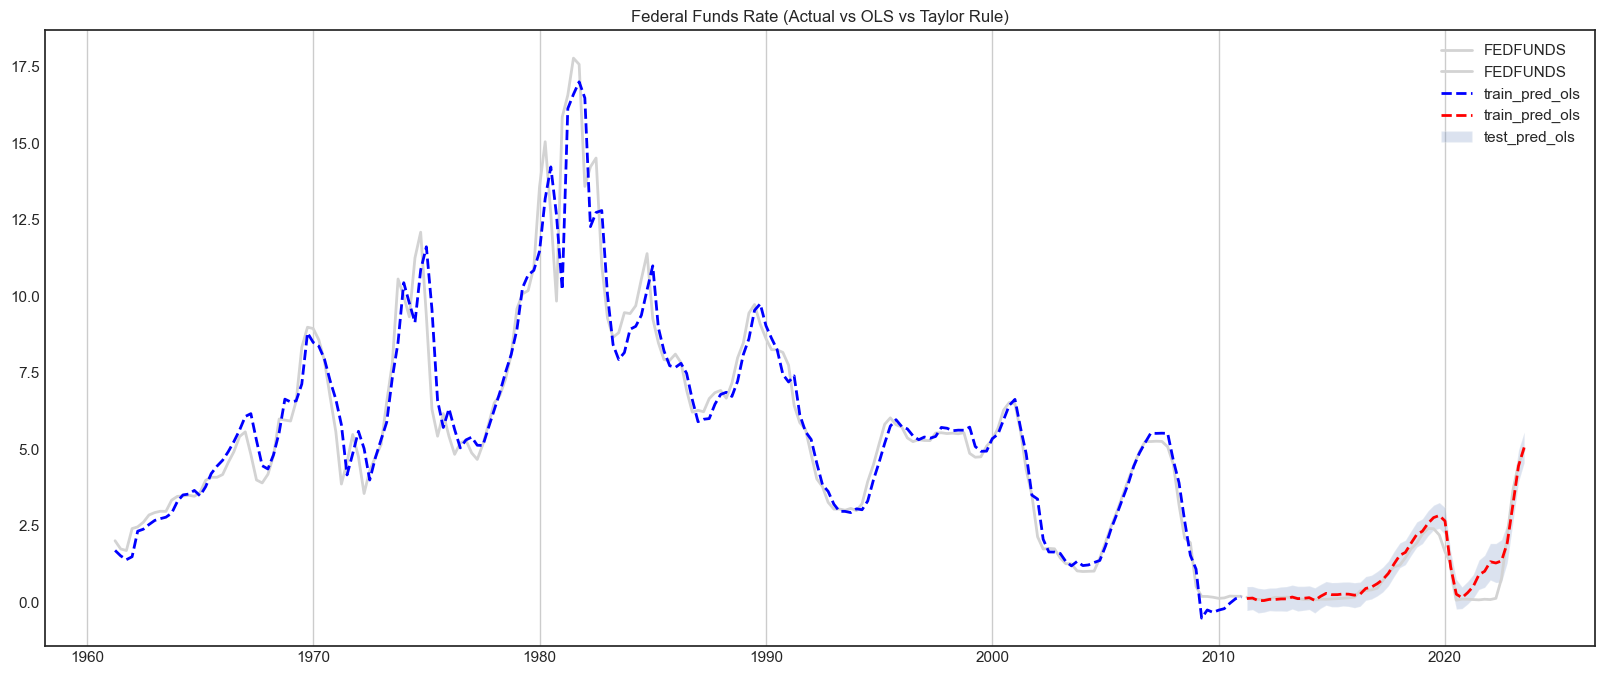

In [34]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# Lasso

In [35]:
# Lasso with 5 fold cross-validation
model = linear_model.LassoCV(cv=5, random_state=rand_int, max_iter=10000)

# Fit model
model.fit(X_train_trf, y_train)

print('model.alpha_: ', model.alpha_)

model.alpha_:  0.011159360333333333


In [36]:
lasso_best = linear_model.Lasso(alpha=model.alpha_)
lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [37]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df

coef
num__FEDFUNDS-1                          0.936909
num__gap_inf                             0.122368
num__gap_gdp                             0.124138
num__Real_Interest_Rate                 -0.031288
cat__onehotencoder__recession_flag_True -0.611876

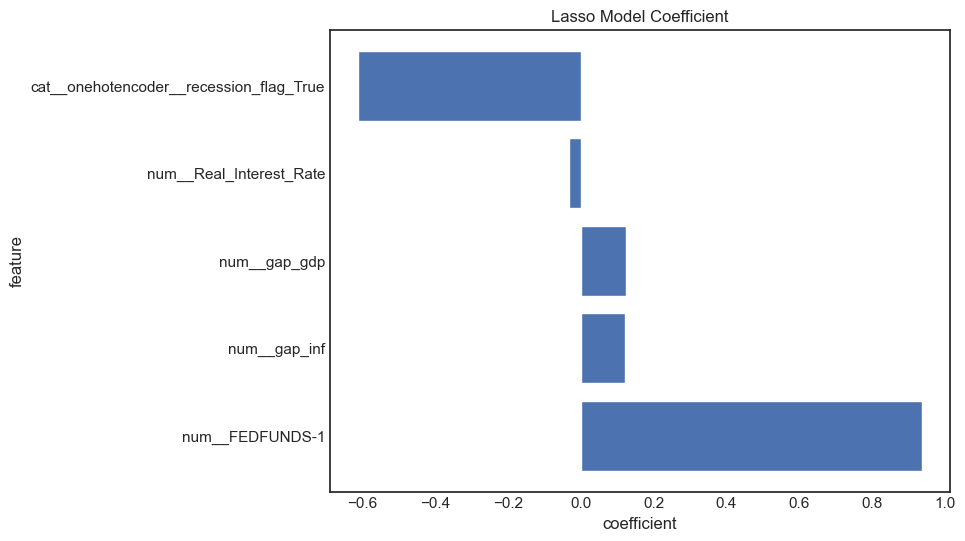

In [38]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

In [39]:
model_stats_df = model_results('lasso_train', y_train, train_pred_lasso, X_train.shape[0], 2 , model_stats_df )

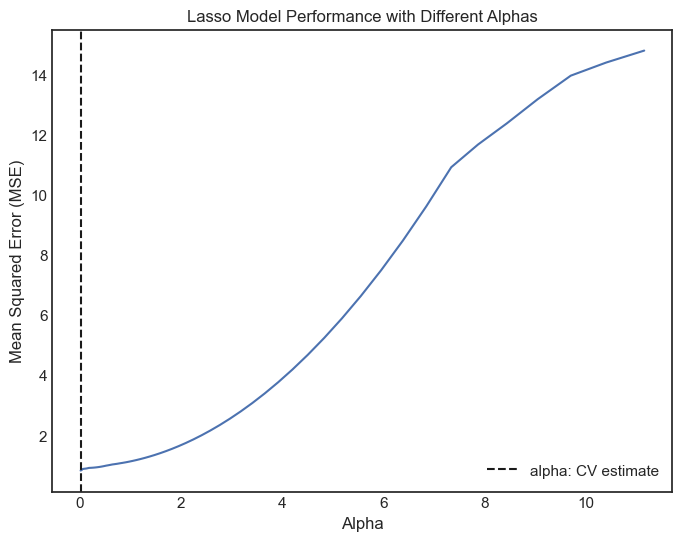

In [40]:
mse_values = np.mean(model.mse_path_, axis=1)

# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.plot(model.alphas_, mse_values)

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Model Performance with Different Alphas')
plt.grid(False)
plt.show()

(-0.5462506883166672,
 11.716770381983334,
 -1.3522679868549297,
 30.890943545008962)

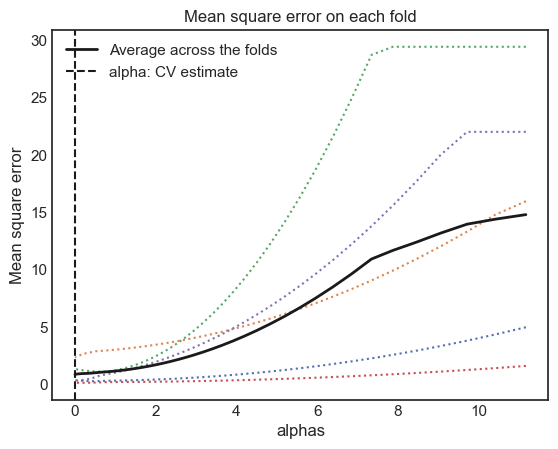

In [41]:
#plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

#ymin, ymax = 50000, 250000
#plt.ylim(ymin, ymax);

In [69]:
test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

test_pred_lasso:  (50,)


In [44]:
model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test_trf.shape[0], X_test_trf.shape[1] , model_stats_df )

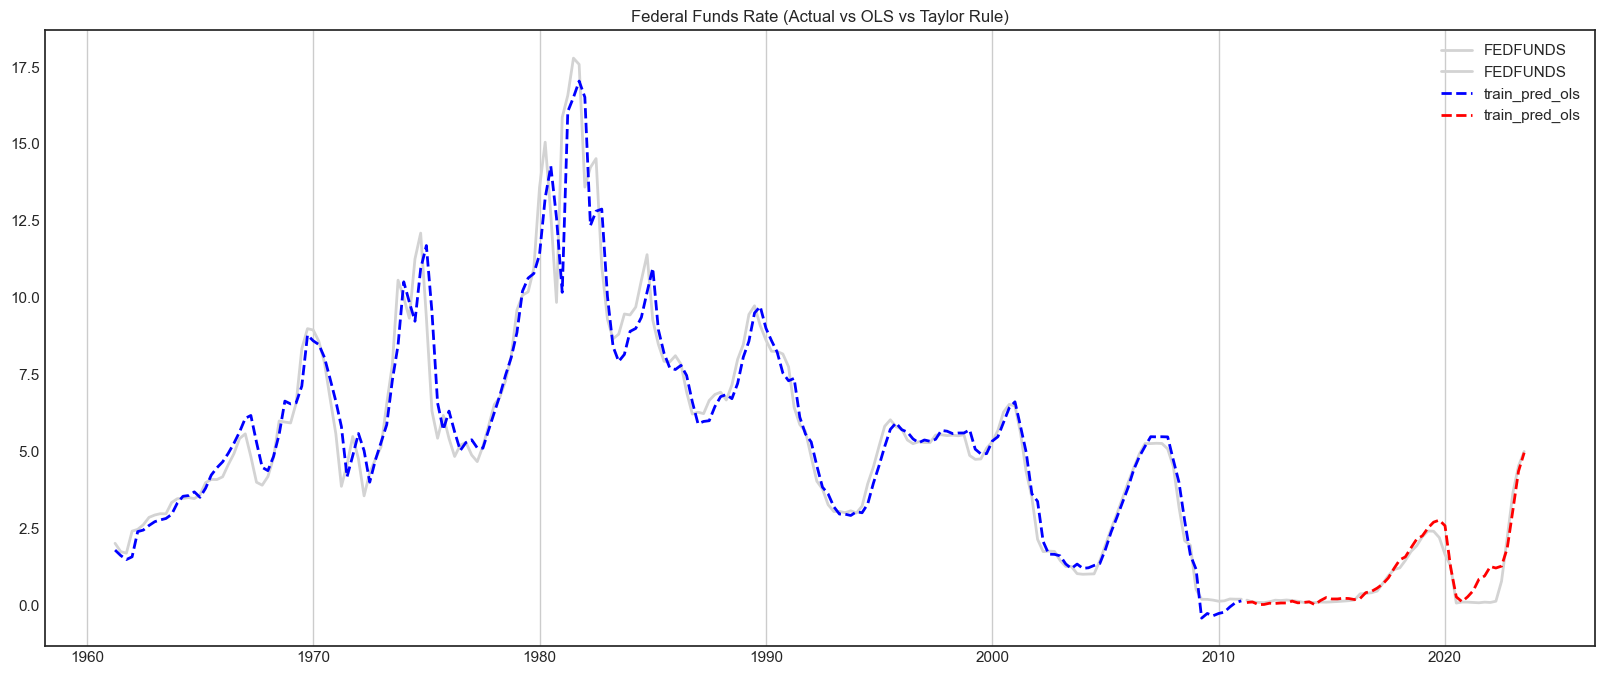

In [45]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# LGBM

In [46]:
ltb_model = ltb.LGBMRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_lgbm = ltb_model.predict(X_train_trf, pred_contrib=False, raw_score=False)

<Axes: >

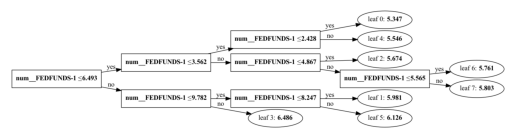

In [47]:
ltb.plot_tree(ltb_model)

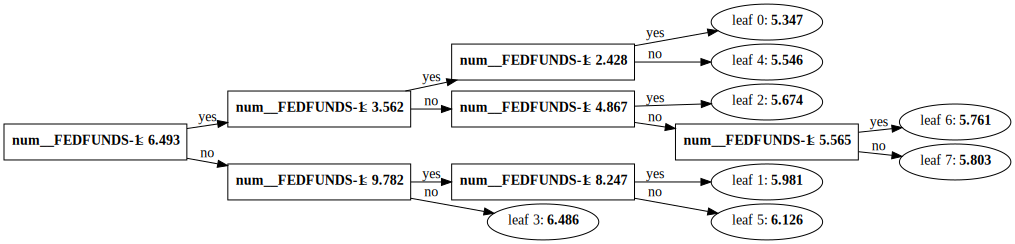

In [48]:
ltb.create_tree_digraph(ltb_model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

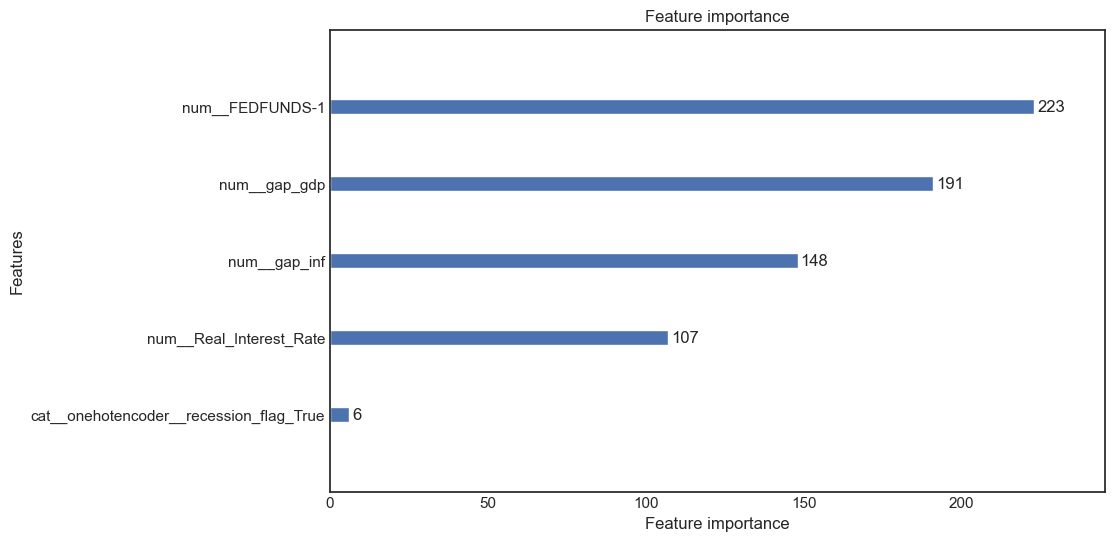

In [49]:
ltb.plot_importance(ltb_model, ignore_zero=False, grid=False, figsize=(10,6))

In [50]:
model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], 2  , model_stats_df )

## Test

In [51]:
test_pred_lgbm = ltb_model.predict(X_test_trf, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(50,)

In [52]:
model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_train.shape[0], 2 , model_stats_df )

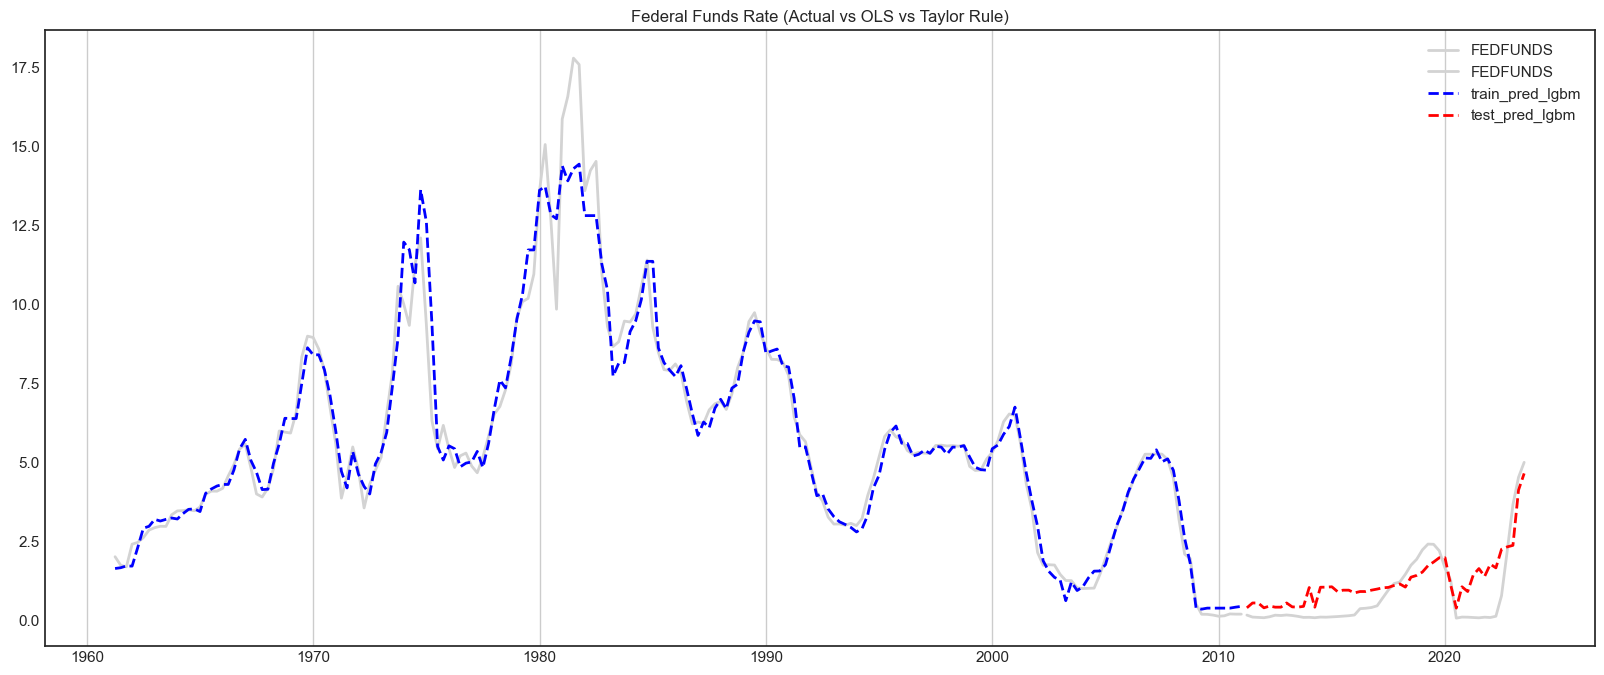

In [53]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# XGB

In [54]:
xgb_model = xgb.XGBRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_xgb = xgb_model.predict(X_train_trf)
xgb_model.score(X_train_trf, y_train)

0.9999998480740064

In [55]:
model_stats_df = model_results('xgb_train', y_train, train_pred_xgb, X_train.shape[0], 2 , model_stats_df )

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

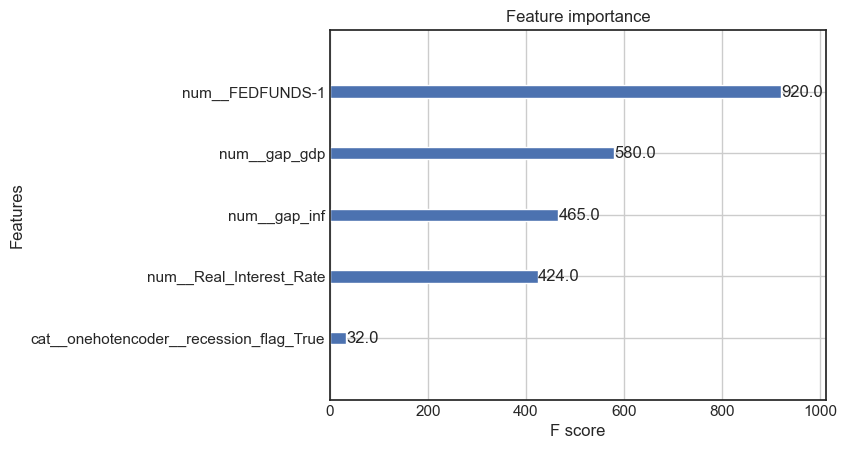

In [56]:
xgb.plot_importance(xgb_model)

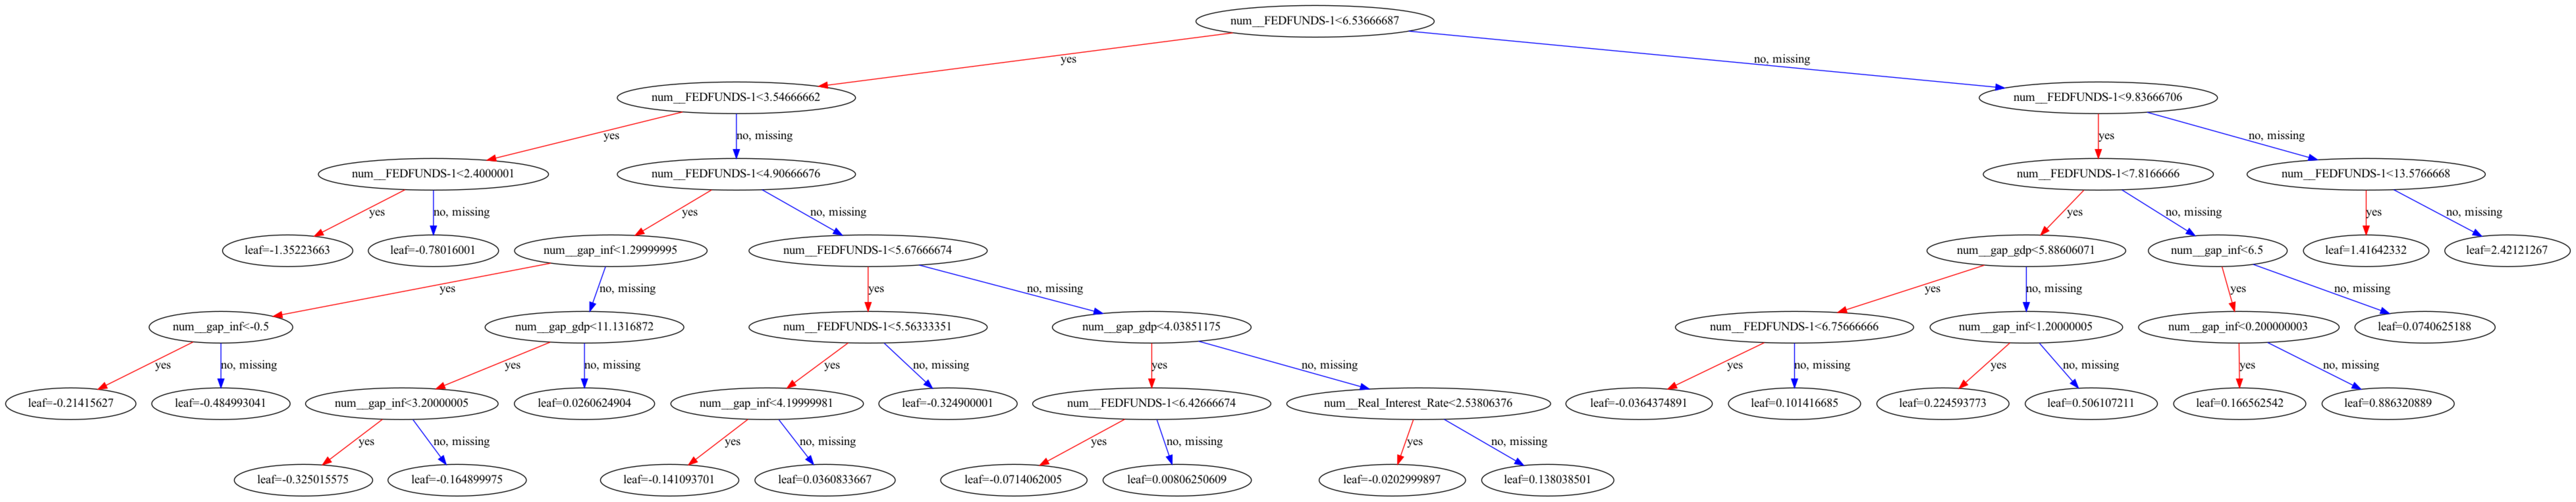

In [57]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(xgb_model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

fig.show()

## Test

In [58]:
test_pred_xgb = xgb_model.predict(X_test_trf)
test_pred_xgb.shape

(50,)

In [59]:
model_stats_df = model_results('xgb_test', y_test, test_pred_xgb, X_train.shape[0], 2 , model_stats_df )

# AdaBoostRegressor

In [60]:
ada_model = AdaBoostRegressor().fit(X_train_trf, y_train)
train_pred_ada = ada_model.predict(X_train_trf)

model_stats_df = model_results('ada_test', y_train, train_pred_ada, X_train_trf.shape[0], 2 , model_stats_df )

In [61]:
test_pred_ada = ada_model.predict(X_test_trf)
model_stats_df = model_results('ada_test', y_test, test_pred_ada, X_train_trf.shape[0], 2 , model_stats_df )

# tsa.SARIMAX

taylor2006_df = load_taylor()
#taylor2006_df = taylor2006_df.query('index < "2007-01-01"')
taylor2006_df

train2006_df, test2006_df = time_split(taylor2006_df)

X_train = train2006_df[['FEDFUNDS-1','gap_inf', 'gap_gdp','recession_flag']]
X_train_trf = t_fit.transform(X_train)


y_train = train2006_df['FEDFUNDS']

In [62]:
model = sm.tsa.SARIMAX(y_train, exog=X_train_trf)
result_model = model.fit(disp=False)

result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  200
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -251.232
Date:                Tue, 21 Nov 2023   AIC                            516.465
Time:                        19:40:27   BIC                            539.553
Sample:                    03-31-1961   HQIC                           525.808
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
num__FEDFUNDS-1                             0.9026      0.031     29.262      0.000       0.842       0.963
num__gap_inf                                0.1586      0.039      4.059      0.000       0.082       0.235
num__gap_gdp                                0.1138      0.048      2.365      0.018       0.020       0.208
num__Real_Interest_Rate                    -0.0995      0.124     -0.804      0.422      -0.342       0.143
cat__onehotencoder__recession_flag_True    -0.6850      0.199     -3.447      0.001      -1.074      -0.296
ar.L1                                       0.1499      0.065      2.312      0.021       0.023       0.277
sigma2                                      0.7220      0.037     19.511      0.000       0.649       0.795
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              1602.11
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [64]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS        mean   mean_se  mean_ci_lower  mean_ci_upper
1961-03-31  1.748348  0.859423       0.063910       3.432787
1961-06-30  1.560889  0.859423      -0.123550       3.245327
1961-09-30  1.428946  0.859423      -0.255492       3.113384
1961-12-31  1.509845  0.859423      -0.174593       3.194283
1962-03-31  2.316936  0.859423       0.632498       4.001374
...              ...       ...            ...            ...
2009-12-31  0.041038  0.859423      -1.643400       1.725476
2010-03-31  0.106623  0.859423      -1.577815       1.791061
2010-06-30  0.290857  0.859423      -1.393581       1.975295
2010-09-30  0.439707  0.859423      -1.244731       2.124145
2010-12-31  0.504485  0.859423      -1.179953       2.188923

[200 rows x 4 columns]

In [ ]:
model_stats_df = model_results('SARIMAX_train',train_df['FEDFUNDS'], train_pred_SARIM['mean'], X_train.shape[0],X_train.shape[1] , model_stats_df )

## Test

In [65]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [66]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

(50, 4)

In [67]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.head()

lower FEDFUNDS  upper FEDFUNDS
2011-03-31       -0.144552        1.001700
2011-06-30       -0.098096        1.060955
2011-09-30       -0.146913        1.012425
2011-12-31       -0.176149        0.983195
2012-03-31       -0.143659        1.015685

In [ ]:
model_stats_df = model_results('SARIMAX_test', test_df['FEDFUNDS'], test_pred_SARIM['mean'], X_test.shape[0], X_train.shape[1] , model_stats_df )

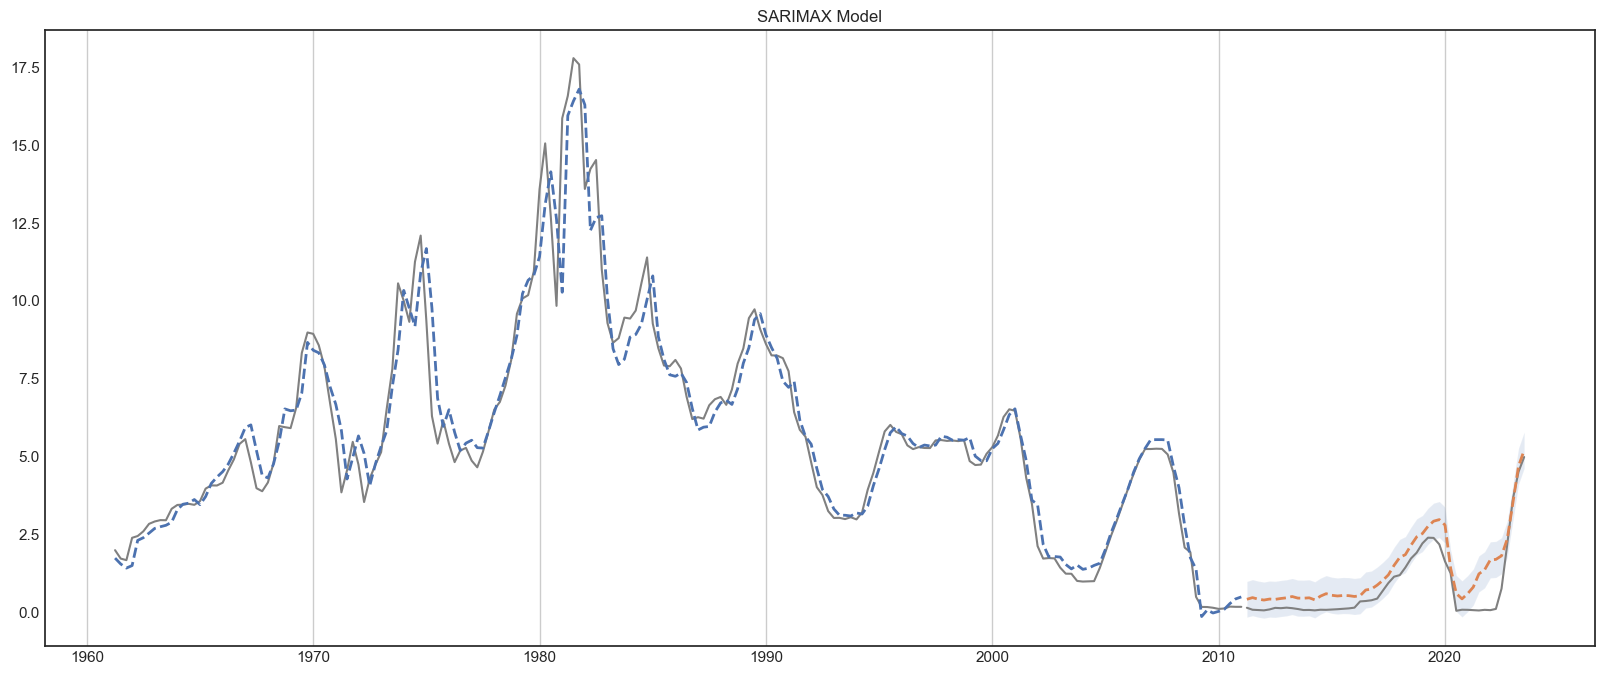

In [72]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS'], predict_ci['upper FEDFUNDS'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [76]:
model_stats_df

name     r_sq  adj_r_sq      mse    rmse
0    ffef_tr_test  -0.9567   -0.9666  22.8365  4.7788
1    ffef_tr_test -39.0258  -39.8596  54.7667  7.4005
2   ffef_tr2_test   0.4458    0.4430   6.4680  2.5432
3   ffef_tr2_test -13.4214  -13.7219  19.7326  4.4421
4      Naive_test   0.9206    0.9206   0.9263  0.9624
5      Naive_test   0.8830    0.8830   0.1601  0.4002
6       ols_train   0.9381    0.9378   0.7227  0.8501
7        ols_test   0.8932    0.8910   0.1462  0.3823
8     lasso_train   0.9379    0.9376   0.7246  0.8513
9      lasso_test   0.9073    0.8991   0.1268  0.3561
10     lgbm_train   0.9523    0.9521   0.5562  0.7458
11      lgbm_test   0.5969    0.5949   0.5516  0.7427
12      xgb_train   1.0000    1.0000   0.0000  0.0013
13       xgb_test   0.7723    0.7711   0.3116  0.5582
14       ada_test   0.9608    0.9606   0.4578  0.6766
15       ada_test   0.3466    0.3433   0.8940  0.9455
16  SARIMAX_train   0.9367    0.9364   0.7388  0.8595
17   SARIMAX_test   0.7412    0.7358   0.3541  0.5951
18  SARIMAX_train   0.9367    0.9354   0.7388  0.8595
19   SARIMAX_test   0.7412    0.7182   0.3541  0.5951